In [1]:
import numpy as np
from matplotlib import pyplot as plt
import Arms as arm
from StochasticBandit import * 
from BanditBaselines import * # you will need UCB alpha to your baselines 

from Experiments import *

In [7]:
class DelayedUCB():
    def __init__(self,nbArms,windowSize,lambda_value,Beta=0.5,tau=0.5,setting='censored'):
        self.nbArms = nbArms
        self.Beta = Beta
        self.setting=setting
        self.lambda_value = lambda_value
        self.tau = tau
        self.windowSize = windowSize
        self.clear()
        
    def clear(self):
        self.nbDraws = np.zeros(self.nbArms)
        self.nbDrawsHat = np.zeros(self.nbArms)
        self.choosenArms = []
        self.cumRewards = np.zeros(self.nbArms)
        self.t = 0
    
    def chooseArmToPlay(self):
        
        # Initialization
        if (min(self.nbDraws)==0):
#             print('index :',-self.nbDraws)
            return randmax(-self.nbDraws)
        
        # t > K
        else:
#             print('conversion_rate : ',self.conversionRateEstimator)
            index = self.conversionRateEstimator + np.sqrt((self.nbDraws*self.Beta(self.t))/(2*self.nbDrawsHat**2))
#             print('index :',index)
            return randmax(index)
    
    
    def receiveReward(self, arm, reward):
        
        # Simple updates
        self.t = self.t + 1
        self.choosenArms.append(arm)
        self.nbDraws[arm] = self.nbDraws[arm] + 1
        
        # Number of draws hat (depending on the setting)
        if self.setting=='censored':
#             print(len(self.choosenArms),len(np.array(self.choosenArms[:self.t-self.windowSize]))+len(np.array(self.choosenArms[self.t-self.windowSize:self.t-1])))
            for arm in range(self.nbArms):
                taus = np.array([self.tau(self.t-(s+1)) for s in range(self.t-self.windowSize,self.t)])
                self.nbDrawsHat[arm] = self.tau(self.windowSize)*np.sum(np.array(self.choosenArms[:self.t-self.windowSize])==arm) + np.sum(taus*(np.array(self.choosenArms[self.t-self.windowSize:self.t])==arm))
        elif self.setting=='uncensored':
            for arm in range(self.nbArms):
                taus=np.array([self.tau(self.t-(s+1)) for s in range(self.t)])
                self.nbDrawsHat[arm] = np.sum(taus*(np.array(self.choosenArms)==arm))
                
        # Sum of rewards
        for arm in range(self.nbArms):
            for time_round in range(self.t):
                for u in range(time_round):
                    if self.choosenArms[u] == arm:
                        self.cumRewards[arm] += reward*(np.random.geometric(self.lambda_value) <= time_round-u)
        
        # Computing Conversion rate
        self.conversionRateEstimator = self.cumRewards/self.nbDrawsHat
        print('conversion rate : ',self.conversionRateEstimator)
        
    
    def name(self):
        if self.setting == 'censored':
            return "DelayedCensoredUCB"
        elif self.setting == 'uncensored':
            return "DelayedUncensoredUCB"

<ipython-input-7-e10575b766bf>:59: RuntimeWarning: invalid value encountered in true_divide
  self.conversionRateEstimator = self.cumRewards/self.nbDrawsHat


conversion rate :  [nan  0. nan]
conversion rate :  [nan  0.  0.]
conversion rate :  [0. 0. 0.]
conversion rate :  [0. 0. 0.]
conversion rate :  [1. 6. 1.]
conversion rate :  [1. 3. 1.]
conversion rate :  [1. 2. 1.]
conversion rate :  [1.  1.5 1. ]
conversion rate :  [1.  1.2 1. ]
conversion rate :  [0.66666667 1.2        1.        ]
conversion rate :  [0.66666667 1.2        0.66666667]
conversion rate :  [0.66666667 1.         0.66666667]
conversion rate :  [7.5        7.66666667 8.66666667]
conversion rate :  [7.5        7.66666667 6.5       ]
conversion rate :  [12.8 19.  15.5]
conversion rate :  [12.8        16.28571429 15.5       ]
conversion rate :  [12.8  14.25 15.5 ]
conversion rate :  [12.8  14.25 12.4 ]
conversion rate :  [24.4        23.33333333 25.6       ]
conversion rate :  [24.4        23.33333333 21.33333333]
conversion rate :  [33.33333333 37.77777778 34.33333333]
conversion rate :  [33.33333333 34.         34.33333333]
conversion rate :  [52.         50.8        43.14

<ipython-input-7-e10575b766bf>:59: RuntimeWarning: invalid value encountered in true_divide
  self.conversionRateEstimator = self.cumRewards/self.nbDrawsHat


conversion rate :  [93.09090909 93.42857143 99.27272727]
conversion rate :  [93.09090909 93.42857143 91.        ]
conversion rate :  [93.09090909 81.75       91.        ]
conversion rate :  [107.83333333 105.25       116.83333333]
conversion rate :  [107.83333333 105.25       107.84615385]
conversion rate :  [ 99.53846154 105.25       107.84615385]
conversion rate :  [ 99.53846154 105.25       100.14285714]
conversion rate :  [127.69230769 120.88888889 128.57142857]
conversion rate :  [159.23076923 148.88888889 148.4       ]
conversion rate :  [178.57142857 181.55555556 177.33333333]
conversion rate :  [178.57142857 163.4        177.33333333]
conversion rate :  [198.66666667 193.6        209.86666667]
conversion rate :  [232.8   226.6   226.875]
conversion rate :  [218.25  226.6   226.875]
conversion rate :  [254.25       262.8        248.35294118]
conversion rate :  [291.25       273.81818182 284.58823529]
conversion rate :  [274.11764706 273.81818182 284.58823529]
conversion rate :  

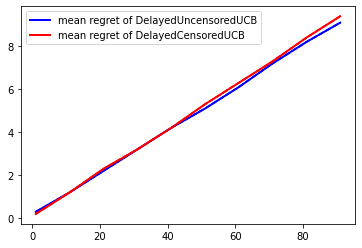

In [8]:
# Creating a MAB
K=3
arms=[arm.Bernoulli(i) for i in [0.5, 0.4, 0.3]]
mab = MAB(arms)


Nexp=1
T=100
mu=5 # expectation of the delay
m=1
epsilon = 0.1

strategy1 = DelayedUCB(nbArms=K,lambda_value=mu**-1,windowSize=m,Beta=lambda x: (1+epsilon)*np.log(x) ,tau=lambda x : 0.5,setting='uncensored')
strategy2 = DelayedUCB(nbArms=K,lambda_value=mu**-1,windowSize=m,Beta=lambda x: (1+epsilon)*np.log(x) ,tau=lambda x : 0.5,setting='censored')

RunExpes([strategy1,strategy2],mab,Nexp,T,step=10,quantiles="on")